In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv("20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv", parse_dates=['reporting_time'])
df = df.set_index('reporting_time')
df = df[df['planning_method_latest']!='no Plan']
# df[['demand', 'demand_lb', 'demand_ub']].describe()


,demand,demand_lb,demand_ub
count,6.175600e+04,6.175600e+04,6.175600e+04
mean,9.732063e+04,5.958392e+04,1.371627e+05
std,3.551535e+05,2.417415e+05,4.942232e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.800000e+03,0.000000e+00,6.000000e+03
75%,5.217700e+04,2.496000e+04,7.500000e+04
max,1.575881e+07,1.344800e+07,1.740668e+07


In [3]:
#Getting all products with more than 18 months of data
no_month = 18
sub_df = df[df.groupby('product_name').product_name.transform('count')>=no_month].copy()
sub_df.product_name.value_counts()

P1817    54
P355     54
P290     54
P291     54
P298     54
         ..
P1384    18
P1398    18
P1400    18
P1401    18
P374     18
Name: product_name, Length: 1250, dtype: int64

In [167]:
# sub_df[sub_df['product_name']=='P290']

<Axes: xlabel='reporting_time'>

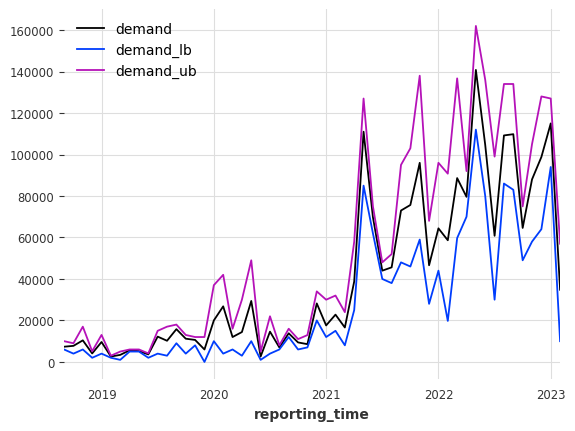

In [555]:
prod_name_indv = 'P737'
test_df = df[df['product_name']==f'{prod_name_indv}']
test_df[['demand', 'demand_lb', 'demand_ub']].plot()

In [340]:
test_df

,product_name,demand,demand_lb,demand_ub,direct_demand_avg_perc,disti_demand_avg_perc,direct_customer_avg_count,disti_customer_avg_count,product_application,product_main_family,...,product_basic_type,planning_method_latest,planning_method_reporting_month,external1,external2,external3,external4,external5,external6,external7
reporting_time,,,,,,,,,,,,,,,,,,,,,
2018-09-01 00:00:00+00:00,P522,243530.0,229030.0,255530.0,5.0,95.0,3.0,7.000000,blau,J,...,BT264,Special,ramp up,0.374087,1.050377,0.365615,-0.441068,-0.390011,-0.195539,0.288269
2018-10-01 00:00:00+00:00,P522,259012.5,173470.0,343470.0,18.5,81.5,1.0,3.750000,blau,J,...,BT264,Special,ramp up,0.225945,0.730145,0.455031,-0.481451,-0.331509,-0.254979,-0.481357
2018-11-01 00:00:00+00:00,P522,368678.0,189690.0,430500.0,7.0,93.0,0.4,3.600000,blau,J,...,BT264,Special,ramp up,-0.301452,0.765124,0.459147,-0.930663,-0.448512,-0.359941,-0.365594
2018-12-01 00:00:00+00:00,P522,339966.0,235040.0,515780.0,12.8,87.2,1.6,2.800000,blau,J,...,BT264,Special,ramp up,-0.402007,0.747046,0.905650,-0.992837,-0.565516,-0.530369,-0.551826
2019-01-01 00:00:00+00:00,P522,232324.2,165877.0,445620.0,15.8,84.2,2.4,3.000000,blau,J,...,BT264,Special,ramp up,-0.831873,-0.099919,0.146337,-1.048813,-0.448512,-0.644249,-0.527546
2019-02-01 00:00:00+00:00,P522,191838.0,102470.0,305780.0,24.0,76.0,1.0,2.200000,blau,J,...,BT264,Special,ramp up,-0.914978,0.091813,0.234929,-1.441132,-0.243757,-0.619349,-0.304991
2019-03-01 00:00:00+00:00,P522,226464.6,189990.0,277480.0,23.6,76.4,2.0,3.800000,blau,J,...,BT264,Special,ramp up,-0.981561,0.633369,1.188572,-1.495515,-0.214506,-0.485391,-0.080020
2019-04-01 00:00:00+00:00,P522,344578.0,184704.0,445462.0,22.4,77.6,2.0,4.600000,blau,J,...,BT264,Special,ramp up,-0.876274,-0.423761,0.426645,-1.398607,-0.302258,-0.522702,0.623241
2019-05-01 00:00:00+00:00,P522,171762.4,56862.0,335200.0,22.8,77.2,1.4,3.000000,blau,J,...,BT264,Special,ramp up,-0.988189,-0.386443,-0.064816,-1.214524,-0.653268,-0.579419,-0.508615


In [341]:
# #EDA report 
# from pandas_profiling import ProfileReport
# profile = ProfileReport(test_df, tsmode=True, )
# profile.to_file('profile_report.html')

Checking for autocorrelation

Checking for Seasonality

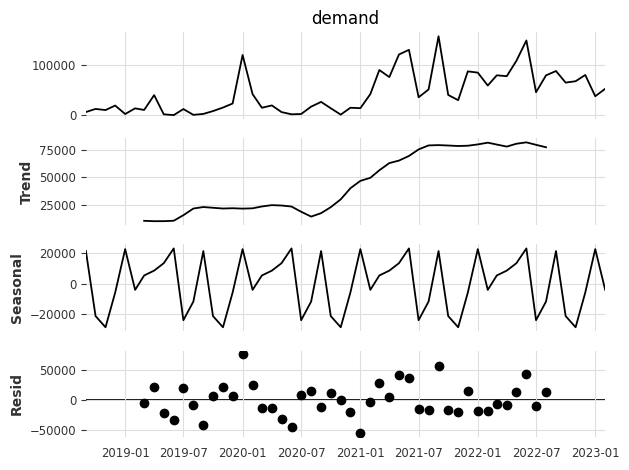

In [544]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_res = seasonal_decompose(test_df.demand, model = 'additive', period=12)
trend = decompose_res.trend
seasonal = decompose_res.seasonal
residual = decompose_res.resid
decomplot = decompose_res.plot()

In [545]:
# https://knk00.medium.com/how-to-determine-seasonality-without-plots-f18cee913b95
from scipy.stats import kruskal

def seasonality_test(df, columns, periods):
    my_dict = {}
    idx = np.arange(len(df.index)) % 12
    for name in columns:
        my_dict[name] = False
        H_statistic, p_value = kruskal(df[f'{name}'], idx)
        if p_value <= 0.05:
            seasonal = True
            my_dict[name] = seasonal
    return my_dict
    

# Darts

In [546]:
from darts.models import AutoARIMA, ExponentialSmoothing, TBATS, Theta, NBEATSModel, RNNModel
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode
from darts import TimeSeries

from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (Scaler, MissingValuesFiller, Mapper, InvertibleMapper)

In [547]:
seasonality_test(df = test_df[['demand', 'demand_lb', 'demand_ub']], columns=['demand', 'demand_lb', 'demand_ub'], periods=12)

{'demand': True, 'demand_lb': True, 'demand_ub': True}

In [552]:
test_df = test_df[['demand', 'demand_lb', 'demand_ub', 'external1', 'external2', 
                   'external3', 'external4', 'external5', 'external6', 'external7']]
train = 0.7
val = 0.2
test = 0.1

scaler_train = Scaler()
scaler_val_all = Scaler()
scaler_val_uni = Scaler()
scaler_val_cov = Scaler()
scaler_test = Scaler()

length = len(test_df)
darts_df = TimeSeries.from_dataframe(test_df)
# darts_df = TimeSeries.from_series(test_df.demand_lb)
train_set, val_test= darts_df.split_before(train)
val_set, test_set = val_test.split_before(2/3)

train_set = scaler_train.fit_transform(train_set)
val_set_all = scaler_val_all.fit_transform(val_set)
val_set_uni = scaler_val_uni.fit_transform(val_set['demand'])
val_set_cov = scaler_val_cov.fit_transform(val_set[['demand', 'demand_lb', 'demand_ub']])

test_set = scaler_test.fit_transform(test_set)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


Fininding highly correlated factors using VIF

In [527]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(df, threshold = 10):
    vif_df = calc_VIF(df)
    return list(remove_VIF(df, vif_df, threshold=threshold).drop(columns=f'VIF_{threshold}')['variables'])

def remove_VIF(df_1, df_2, threshold):
    df_2[f'VIF_{threshold}'] = df_2['VIF'].apply(lambda x : True if x <=threshold else False)
    while df_2[f'VIF_{threshold}'].sum() != len(df_2):
        dropped_col = df_2[df_2['VIF'] == df_2['VIF'].max()]['variables'].item()
        df_1 = df_1.drop(columns= dropped_col)
        df_2 = calc_VIF(df_1)
        df_2[f'VIF_{threshold}'] = df_2['VIF'].apply(lambda x : True if x <=5 else False)
    return df_2

def calc_VIF(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif


AutoArima

model AutoARIMA(information_criterion=hqic) obtains SMAPE: 40.902153836136875%


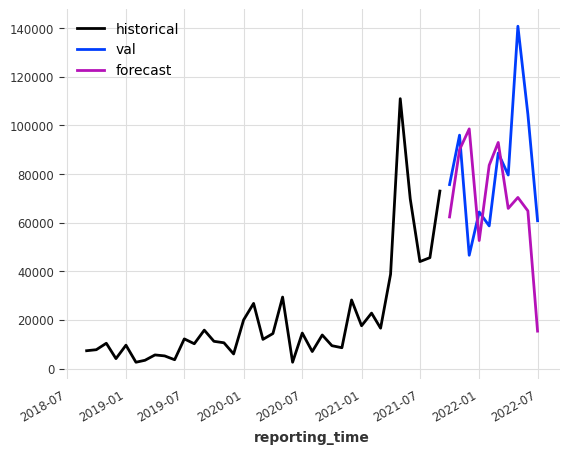

In [554]:
external_variables = VIF(test_df[['external1', 'external2', 'external3', 'external4', 'external5', 'external6', 'external7']])

autoArima = AutoARIMA(information_criterion = 'hqic')

def eval_model(model, train, val):
    model.fit(series=train['demand'],
              future_covariates=train[external_variables])
    forecast=model.predict(len(val['demand']), future_covariates = val[external_variables])
    forecast=scaler_val_uni.inverse_transform(forecast)
    val = scaler_val_all.inverse_transform(val)
    print(f"model {model} obtains SMAPE: {smape(val['demand'], forecast)}%")
    scaler_train.inverse_transform(train)['demand'].plot(label='historical')
    val['demand'].plot(label='val')
    forecast.plot(label = 'forecast')

eval_model(model=autoArima, train=train_set, val=val_set_all)



In [561]:
import joblib
filename = f'{prod_name_indv}.sav'
joblib.dump(autoArima, filename=f'models/{filename}')

['models/P737.sav']

In [ ]:
loaded_model = joblib.load(f'models/P737.sav')

loaded_model.predict(len(val_set_all['demand']), future_covariates = val_set_all[external_variables])

RNNModel

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 2.6 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.40it/s, train_loss=0.036] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s, train_loss=0.036]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.71it/s]
SMAPE of RNNModel(model=GRU, input_chunk_length=37): 41.716206596058775%


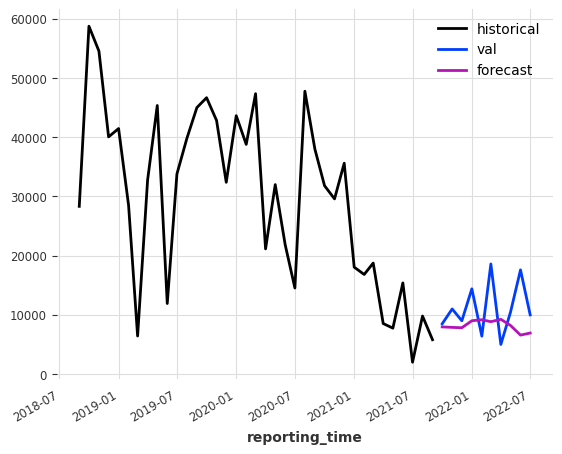

In [530]:
external_variables = VIF(test_df[['external1', 'external2', 'external3', 'external4', 'external5', 'external6', 'external7']])

model_rnn = RNNModel(input_chunk_length = len(train_set), model='GRU')

model_rnn.fit(series=train_set['demand'], future_covariates=train_set[external_variables])
forecast = scaler_val_uni.inverse_transform(model_rnn.predict(len(val_set_all['demand']), future_covariates = (train_set.append(val_set_all))[external_variables]))
val_set_inv = scaler_val_all.inverse_transform(val_set_all)
print(f"SMAPE of {model_rnn}: {smape(val_set_inv['demand'], forecast)}%")


scaler_train.inverse_transform(train_set)['demand'].plot(label='historical')
val_set_inv['demand'].plot(label='val')
forecast.plot(label = 'forecast')


Facebook Prophet

19:36:55 - cmdstanpy - INFO - Chain [1] start processing
19:36:55 - cmdstanpy - INFO - Chain [1] done processing


SMAPE of Prophet(add_seasonalities={'name': 'year', 'seasonal_periods': 12, 'fourier_order': 15}): 82.48543924997855%


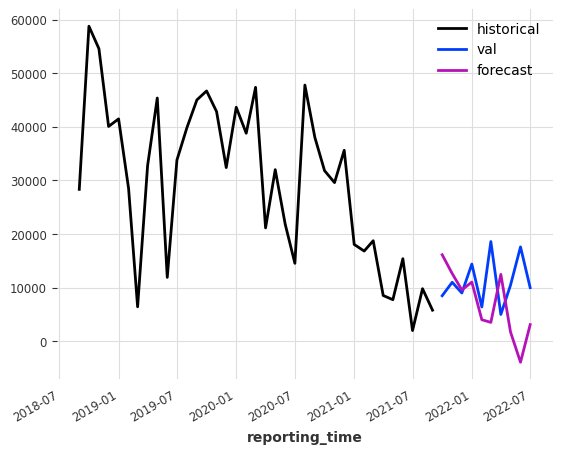

In [531]:
from darts.models import Prophet

external_variables = VIF(test_df[['external1', 'external2', 'external3', 'external4', 'external5', 'external6', 'external7']], threshold=5)

seasnonalities = {'name':'year', 
                  'seasonal_periods':12,
                  'fourier_order':15,
                  }

model_prophet = Prophet(add_seasonalities = seasnonalities)

model_prophet.fit(series = train_set['demand'], future_covariates=train_set[external_variables])
forecast = model_prophet.predict(len(val_set_all), future_covariates = (train_set.append(val_set_all))[external_variables])

forecast = scaler_val_uni.inverse_transform(forecast)
val_set_inv = scaler_val_all.inverse_transform(val_set_all)

scaler_train.inverse_transform(train_set)['demand'].plot(label='historical')
val_set_inv['demand'].plot(label='val')
forecast['demand'].plot(label = 'forecast')

print(f"SMAPE of {model_prophet}: {smape(val_set_inv['demand'], forecast)}%")

Temporal Fusion Transformer https://arxiv.org/pdf/1912.09363.pdf

In [566]:
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression

external_variables = VIF(test_df[['external1', 'external2', 'external3', 'external4', 'external5', 'external6', 'external7']], threshold=5)

quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

input_chunk_length = len(test_set)
forecast_horizon = len(val_set_ot)
model_tft = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=8,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    optimizer_kwargs = {'lr': 1e-3}
)

model_tft.fit(train_set[['demand', 'demand_lb', 'demand_ub']], future_covariates = (train_set.append(val_set_all))[external_variables], verbose = True)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 16.2 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 10.6 K
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K
8  | static_cont

Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  7.67it/s, train_loss=0.223]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  7.55it/s, train_loss=0.223]


TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x00000169F5FE4BE0>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=7, output_chunk_length=10, batch_size=16, n_epochs=300, add_encoders=None, random_state=42, optimizer_kwargs={'lr': 0.001})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
SMAPE of TFTModel(hidden_size=64, num_attention_heads=8, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x00000169F5FE4BE0>, input_chunk_length=7, output_chunk_length=10, batch_size=16, n_epochs=300, random_state=42, optimizer_kwargs={'lr': 0.001}): 
31.36192336842602%


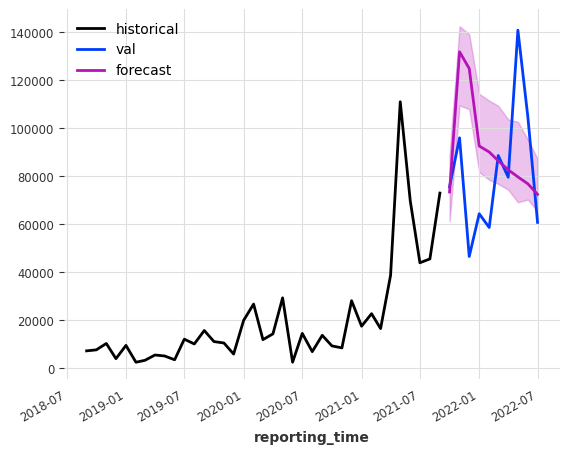

In [567]:
forecast = model_tft.predict(n=forecast_horizon, num_samples = 200)

forecast = scaler_val_cov.inverse_transform(forecast)
val_set_inv = scaler_val_all.inverse_transform(val_set_all)

scaler_train.inverse_transform(train_set)['demand'].plot(label='historical')
val_set_inv['demand'].plot(label='val')
forecast['demand'].plot(label = 'forecast')

print(f"SMAPE of {model_tft}: \n{smape(val_set_inv['demand'], forecast['demand'])}%")

In [568]:
#Deterministic Forecast
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
import torch

external_variables = VIF(test_df[['external1', 'external2', 'external3', 'external4', 'external5', 'external6', 'external7']], threshold=5)

quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

input_chunk_length = len(test_set)
forecast_horizon = len(val_set)
model_tft = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=8,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=None,
    loss_fn=torch.nn.MSELoss(),
    random_state=42,
    optimizer_kwargs = {'lr': 1e-3}
)

model_tft.fit(train_set[['demand', 'demand_lb', 'demand_ub']], future_covariates = (train_set.append(val_set))[external_variables], verbose = True)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 16.2 K
6  | decoder_vsn                       | _VariableSelectionNetwork        | 10.6 K
7  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
8  | static_cont

Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s, train_loss=0.00429]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s, train_loss=0.00429]


TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=7, output_chunk_length=10, batch_size=16, n_epochs=300, add_encoders=None, random_state=42, optimizer_kwargs={'lr': 0.001})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
SMAPE of TFTModel(hidden_size=64, num_attention_heads=8, loss_fn=MSELoss(), input_chunk_length=7, output_chunk_length=10, batch_size=16, n_epochs=300, random_state=42, optimizer_kwargs={'lr': 0.001}): 
35.92940994995406%


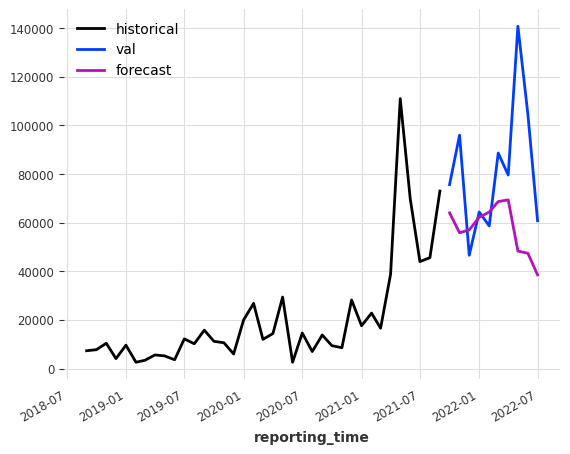

In [569]:
forecast = model_tft.predict(n=forecast_horizon, num_samples = 1)
forecast = scaler_val_cov.inverse_transform(forecast)
val_set_inv = scaler_val_all.inverse_transform(val_set_all)

scaler_train.inverse_transform(train_set)['demand'].plot(label='historical')
val_set_inv['demand'].plot(label='val')
forecast['demand'].plot(label = 'forecast')

print(f"SMAPE of {model_tft}: \n{smape(val_set_inv['demand'], forecast['demand'])}%")

D-Linear

In [576]:
from darts.models import DLinearModel

quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

input_chunk_length = len(test_set)
forecast_horizon = len(val_set)
model_dlin = DLinearModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    shared_weights = False,
    kernel_size=25,
    const_init= True,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    optimizer_kwargs = {'lr': 1e-3}
)

model_dlin.fit(train_set[['demand', 'demand_lb', 'demand_ub']], future_covariates = (train_set.append(val_set))[external_variables], verbose = True)




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 32.6 K
5 | linear_trend    | Linear           | 32.6 K
6 | linear_fut_cov  | Linear           | 357   
-----------------------------------------------------
65.6 K    Trainable params
0         Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 62.71it/s, train_loss=0.290]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.02it/s, train_loss=0.290]


DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=7, output_chunk_length=10, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x00000169E4B28E20>, random_state=42, optimizer_kwargs={'lr': 0.001})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


SMAPE of DLinearModel(input_chunk_length=7, output_chunk_length=10, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x00000169E4B28E20>, random_state=42, optimizer_kwargs={'lr': 0.001}): 
90.45108352053231%


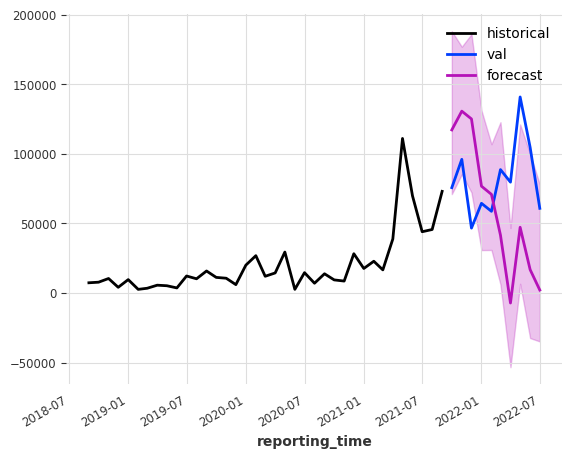

In [577]:
forecast = model_dlin.predict(n=forecast_horizon, num_samples = 200)

forecast = scaler_val_cov.inverse_transform(forecast)
val_set_inv = scaler_val_all.inverse_transform(val_set_all)

scaler_train.inverse_transform(train_set)['demand'].plot(label='historical')
val_set_inv['demand'].plot(label='val')
forecast['demand'].plot(label = 'forecast')



print(f"SMAPE of {model_dlin}: \n{smape(val_set_inv['demand'], forecast['demand'])}%")